In [1]:
import pandas as pd
import numpy as np
import StressTools as tools
import utils
import cycloidData
import matplotlib.pyplot as plt

## Import interior structures for SIMON and MEW

In [2]:
interior = utils.import_interior('interior1')

overrides = {
    'obliquity': np.radians(0.1),
    'obliquityPhase': 0.0,
    'obliquityPhaseRate': 0,
    'spinRate': 0,
    'nonSynchronusRotationRate': 0,
    'librationAmplitude': 0,
    'librationPhase': 0,
    'librationFrequency': 0
}
europa_orbit_seconds = 85 * 3600

sat = utils.import_structure('Sample', overrides)

In [3]:
cycloids = cycloidData.load_all_cycloids()

## Testing

In [19]:
simon_points = cycloids['mira'].curve.head(10).copy()
mew_points = cycloids['mira'].curve.head(10).copy()

mew_points['lon'] = np.radians(360 - mew_points['lon'])
mew_points['lat'] = np.radians(90 - mew_points['lat'])

In [20]:
mew_field = tools.build_mew_stress_field(sat, europa_orbit_seconds, mew_points)
mew_field['lat'] = 90 - np.degrees(mew_field.lat)
mew_field['lon'] = 360 - np.degrees(mew_field.lon)
mew_field = mew_field.sort_values(['lat', 'lon', 'time'])

In [21]:
simon_field = tools.build_simon_stress_field(interior, simon_points, 0, 0.01, np.radians(0.1), 0)

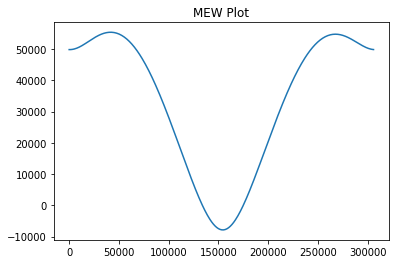

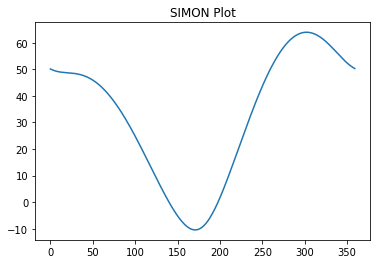

In [24]:
point = 1

min_row = 360 * (point - 1)
max_row = 360 * point

mew_first = mew_field[min_row:max_row]
plt.plot(mew_first.time, mew_first.principal1)
# plt.plot(mew_first.time, mew_first.principal2)
plt.title('MEW Plot')

plt.figure()

plt.title('SIMON Plot')
simon_first = simon_field[min_row:max_row]
plt.plot(simon_first.time, simon_first.stress)


# TODO:

### Run comparison on each different cycloid

### Quantify Difference between MEW and SIMON in some way
  - How do we handle differences in phase shift (x axis shift)?
  - We want to consider an overall shape matching as good
  
Looks like `np.corrcoef` can provide a good similarity value while taking phase shifting into consideration. Values in the matrix outside of the diagonal will provide the similarity value (0.0 - 1.0).


In [25]:
def check_similarity(cycloid_point):
    simon_points = cycloid_point.copy()
    mew_points = cycloid_point.copy()

    mew_points['lon'] = np.radians(360 - mew_points['lon'])
    mew_points['lat'] = np.radians(90 - mew_points['lat'])
    mew_field = tools.build_mew_stress_field(sat, europa_orbit_seconds, mew_points)
    
    # make sure mew field is sorted the same as the simon field will be
    mew_field['lat'] = 90 - np.degrees(mew_field.lat)
    mew_field['lon'] = 360 - np.degrees(mew_field.lon)
    mew_field = mew_field.sort_values(['lat', 'lon', 'time'])
    
    simon_field = tools.build_simon_stress_field(interior, simon_points, 0, 0.01, np.radians(0.1), 0)
    
    mew_stress = [stress / max(mew_field.principal1) for stress in mew_field.principal1]
    simon_stress = [stress / max(simon_field.stress) for stress in simon_field.stress]
    
    similarity = np.corrcoef(mew_stress, simon_stress)[1, 0]
    print('Similarity: ', similarity)
    
    return dict(similarity=similarity, mew_max=max(mew_field.principal1)/1000,
               mew_min=min(mew_field.principal1)/1000, simon_max=max(simon_field.stress),
               simon_min=min(simon_field.stress))

In [26]:
results = []

for cycloid in cycloids:
    point = cycloids[cycloid].curve.head(1)
    result = check_similarity(point)
    result['cycloid'] = cycloid
    results.append(result)
    
similarity_frame = pd.DataFrame(results)
display(similarity_frame)

Similarity:  0.9939081063170494
Similarity:  0.9995458375418518
Similarity:  0.9362308290354978
Similarity:  0.9861643052484907
Similarity:  0.9997060736565937
Similarity:  0.9307351199213052
Similarity:  0.9668519160621779
Similarity:  0.9862968619461256
Similarity:  0.9998344664210962
Similarity:  0.9988178491764714


,similarity,mew_max,mew_min,simon_max,simon_min,cycloid
0,0.993908,77.149503,-59.021626,75.396939,-58.558192,alex
1,0.999546,87.166583,-63.649322,91.740447,-68.573028,carly
2,0.936231,82.432346,25.219692,73.295229,24.506098,cilicia
3,0.986164,89.233322,18.573146,85.338739,16.949147,delphi
4,0.999706,97.720075,-67.161392,98.935079,-67.853406,dirk
5,0.930735,55.436452,-7.514695,63.989232,-10.472471,mira
6,0.966852,63.169281,-17.018274,71.851968,-22.368530,odessa
7,0.986297,89.235653,18.548216,85.365177,16.918989,sidon
8,0.999834,96.744196,-67.479610,98.486559,-68.993371,tyrrel
9,0.998818,72.869384,-68.385699,73.830856,-70.012054,yaphet


In [ ]:
from scipy.signal import correlate


In [ ]:
mew_stress = [stress / max(mew_first.principal1) for stress in mew_first.principal1]
simon_stress = [stress / max(simon_first.stress) for stress in simon_first.stress]

# result = correlate(mew_stress, simon_stress, method='fft')

# plt.plot(result)

In [ ]:
similarity = np.corrcoef(mew_stress, simon_stress)[1, 0]
similarity

In [ ]:
result = correlate(mew_stress, mew_stress)
plt.plot(result)

In [ ]:
np.correlate(mew_stress, simon_stress)

In [ ]:
junk = np.random.rand(len(mew_stress))
result = correlate(mew_stress, junk)
plt.plot(result)

In [ ]:
np.correlate(mew_stress, junk)